In [1]:
import tensorflow as tf

### configurando o tamanho do lote e as dimensões das imagens

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (100, 100)

### Carregando os dados de treino, validação e teste

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory('./train', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, color_mode='grayscale')
val_dataset = tf.keras.utils.image_dataset_from_directory('./val', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, color_mode='grayscale')
test_dataset = tf.keras.utils.image_dataset_from_directory('./test', batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, color_mode='grayscale')

Found 8621 files belonging to 2 classes.
Found 5747 files belonging to 2 classes.
Found 2874 files belonging to 2 classes.


### configurando os datasets para melhor performance

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### configurando objetos para hiper-parâmetros

In [9]:
optim = tf.optimizers.Adamax(learning_rate=.001, beta_1=.95)
loss = tf.losses.BinaryCrossentropy(from_logits=True)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
decay = tf.keras.callbacks.ReduceLROnPlateau('val_accuracy', 0.5, patience=10, min_lr=0.001, mode='max')
initializer = tf.keras.initializers.RandomUniform(minval=-.03, maxval=.03, seed=42)
regularizer = tf.keras.regularizers.L2(.1)

### criando  estrutura do modelo

In [10]:
inp = tf.keras.layers.Input(shape=IMAGE_SIZE + (1,), batch_size=BATCH_SIZE)
inp = tf.keras.layers.Rescaling(1./255)(inp)

hid1 = tf.keras.layers.Conv2D(16, kernel_size=3, kernel_initializer=initializer, kernel_regularizer=regularizer, padding='same', activation='relu')(inp)
hid1 = tf.keras.layers.MaxPooling2D()(hid1)

hid2 = tf.keras.layers.Conv2D(32, kernel_size=3, kernel_initializer=initializer, kernel_regularizer=regularizer, padding='same', activation='relu')(hid1)
hid2 = tf.keras.layers.MaxPooling2D()(hid2)

hid3 = tf.keras.layers.Conv2D(64, kernel_size=3, kernel_initializer=initializer, kernel_regularizer=regularizer, padding='same', activation='relu')(hid2)
hid3 = tf.keras.layers.MaxPooling2D()(hid3)

hid4 = tf.keras.layers.Conv2D(128, kernel_size=3, kernel_initializer=initializer, kernel_regularizer=regularizer, padding='same', activation='relu')(hid3)
hid4 = tf.keras.layers.MaxPooling2D()(hid4)

flat = tf.keras.layers.Flatten()(hid4)
dense1 = tf.keras.layers.Dense(128, activation='relu')(flat)
out = tf.keras.layers.Dense(1)(dense1)

model = tf.keras.Model(inputs=inp, outputs=out)

### compilando e gerando um resumo do modelo

In [15]:
model.compile(optimizer=optim, loss=loss, metrics=[
    tf.keras.metrics.Accuracy(dtype=float), 
    tf.keras.metrics.BinaryAccuracy(dtype=float, threshold=0), 
    tf.keras.metrics.Precision(thresholds=0, dtype=float)])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(32, 100, 100, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (32, 100, 100, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 50, 50, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 50, 50, 32)          4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 25, 25, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (32, 25, 25, 64)          1849

### executando treinamento do modelo

In [16]:
hist = model.fit(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    epochs=150, 
    callbacks=[es, decay], 
    validation_data=val_dataset,
    
)

Epoch 1/150
270/270 [==============================] - 66s 242ms/step - loss: 0.6519 - accuracy: 0.0000e+00 - binary_accuracy: 0.6411 - precision_1: 0.6893 - val_loss: 0.6436 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6471 - val_precision_1: 0.7980 - lr: 0.0010
Epoch 2/150
270/270 [==============================] - 75s 277ms/step - loss: 0.6411 - accuracy: 0.0000e+00 - binary_accuracy: 0.6607 - precision_1: 0.6544 - val_loss: 0.6327 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6640 - val_precision_1: 0.7721 - lr: 0.0010
Epoch 3/150
270/270 [==============================] - 79s 294ms/step - loss: 0.6368 - accuracy: 0.0000e+00 - binary_accuracy: 0.6650 - precision_1: 0.6358 - val_loss: 0.6242 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.6812 - val_precision_1: 0.7520 - lr: 0.0010
Epoch 4/150
270/270 [==============================] - 78s 288ms/step - loss: 0.6255 - accuracy: 0.0000e+00 - binary_accuracy: 0.6732 - precision_1: 0.6392 - val_loss: 0.6118 - val_accura

### visualizando os resultados da rede

In [45]:
loss_ = hist.history['loss']
val_loss_ = hist.history['val_loss']
acc = hist.history['accuracy']
bacc = hist.history['binary_accuracy']
val_bacc = hist.history['val_binary_accuracy']
val_acc = hist.history['val_accuracy']
prec = hist.history['precision_1']
val_precision = hist.history['val_precision_1']

In [20]:
import matplotlib.pyplot as plt

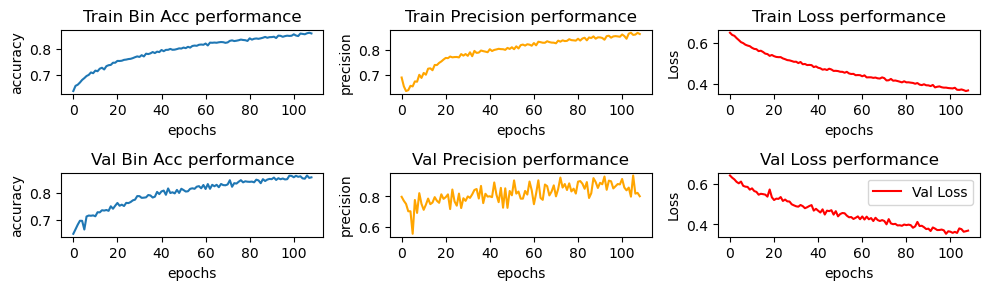

In [53]:
plt.figure(figsize=(10, 4))

x = range(109)
plt.subplot(3, 3, 1)
plt.plot(x, bacc, label='Binary Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Train Bin Acc performance')

plt.subplot(3, 3, 2)
plt.plot(x, prec, label='Precision', c='orange')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.title('Train Precision performance')

plt.subplot(3, 3, 3)
plt.plot(x, loss_, label='Loss', c='red')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Train Loss performance')

# Validation
plt.subplot(3, 3, 4)
plt.plot(x, val_bacc, label='Val Binary Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Val Bin Acc performance')

plt.subplot(3, 3, 5)
plt.plot(x, val_precision, label='Val Precision', c='orange')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.title('Val Precision performance')

plt.subplot(3, 3, 6)
plt.plot(x, val_loss_, label='Val Loss', c='red')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Val Loss performance')

plt.legend()
plt.tight_layout()
plt.show()

### avaliando modelo nos dados de teste

In [39]:
loss, acc, bin_acc, precision = model.evaluate(test_dataset)

90/90 [==============================] - 6s 70ms/step - loss: 0.3634 - accuracy: 0.0000e+00 - binary_accuracy: 0.8643 - precision_1: 0.8665


In [40]:
loss, acc, bin_acc, precision

(0.36344608664512634, 0.0, 0.8643006086349487, 0.8664658665657043)